<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

## Prepare Environment

Jupyter notebook housekeeping

In [1]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline


### Install local canswim package

In [2]:
# pip install -r requirements.txt
# !pip install -e ./

import sys
!{sys.executable} -m pip install -e ./


Obtaining file:///home/ivelin/canswim
  Preparing metadata (setup.py) ... done
  Attempting uninstall: canswim
    Found existing installation: canswim 0.0.1
    Uninstalling canswim-0.0.1:
      Successfully uninstalled canswim-0.0.1
  Running setup.py develop for canswim


## Prepare Model

### Load Data

In [3]:
from canswim.model import CanswimModel

canswim_model = CanswimModel()


n_test_range_days: 630
min_samples: 1890
HFHub init
Configuring CUDA GPU


In [4]:

# canswim_model.covariates.load_institutional_symbol_ownership()

In [5]:
# canswim_model.covariates.inst_symbol_ownership_df

In [6]:
# canswim_model.covariates.inst_symbol_ownership_df.dtypes

In [7]:
# list(canswim_model.covariates.inst_symbol_ownership_df.index.get_level_values(0).unique())

In [8]:
# canswim_model.load_data()

In [9]:
# canswim_model.prepare_data()

In [10]:
# iseries = canswim_model.covariates.prepare_institutional_symbol_ownership_series(stock_price_series=canswim_model.stock_price_series)

In [11]:
# key, value = list(iseries.items())[1]

In [12]:
# key

In [13]:
# value.pd_dataframe()

In [14]:
# value

In [15]:
# value.static_covariates_values()

In [16]:
# value.pd_dataframe().index.has_duplicates

In [17]:
# assert False

In [18]:

canswim_model.load_data()  


Loading data from: data/earnings_calendar.csv.bz2
Loading data from: data/keymetrics_history.csv.bz2
Loading data from: data/institutional_symbol_ownership.csv.bz2
Loading data from: data/analyst_estimates_quarter.csv.bz2
Loading data from: data/analyst_estimates_annual.csv.bz2


In [19]:
# canswim_model.covariates.load_past_covariates()
# canswim_model.covariates.load_future_covariates()

### Prepare Data

In [20]:

def prepare_data():
    canswim_model.prepare_data()
    canswim_model.plot_splits()
    canswim_model.plot_seasonality()



n_stocks:  50
n_epochs:  5
Training loop stock subset: ['ONB', 'MDT', 'PLXS', 'CSGS', 'PGRE', 'RWT', 'NTCT', 'FLIC', 'BLX', 'TER', 'PTCT', 'LILAK', 'KR', 'NEXT', 'BJRI', 'TNET', 'SBH', 'WBS', 'WBD', 'GMS', 'SRDX', 'AWI', 'HMN', 'CYH', 'NEO', 'CASS', 'IBTX', 'HAYN', 'MSI', 'VIAV', 'NPK', 'NVEC', 'GDEN', 'C', 'FORM', 'BDN', 'DZSI', 'BIG', 'A', 'SCVL', 'TFX', 'MMI', 'JACK', 'CAT', 'KDP', 'DXPE', 'ADBE', 'CF', 'SCWO', 'OCN']
Preparing ticker series for 50 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
stacking covariates
preparing past co

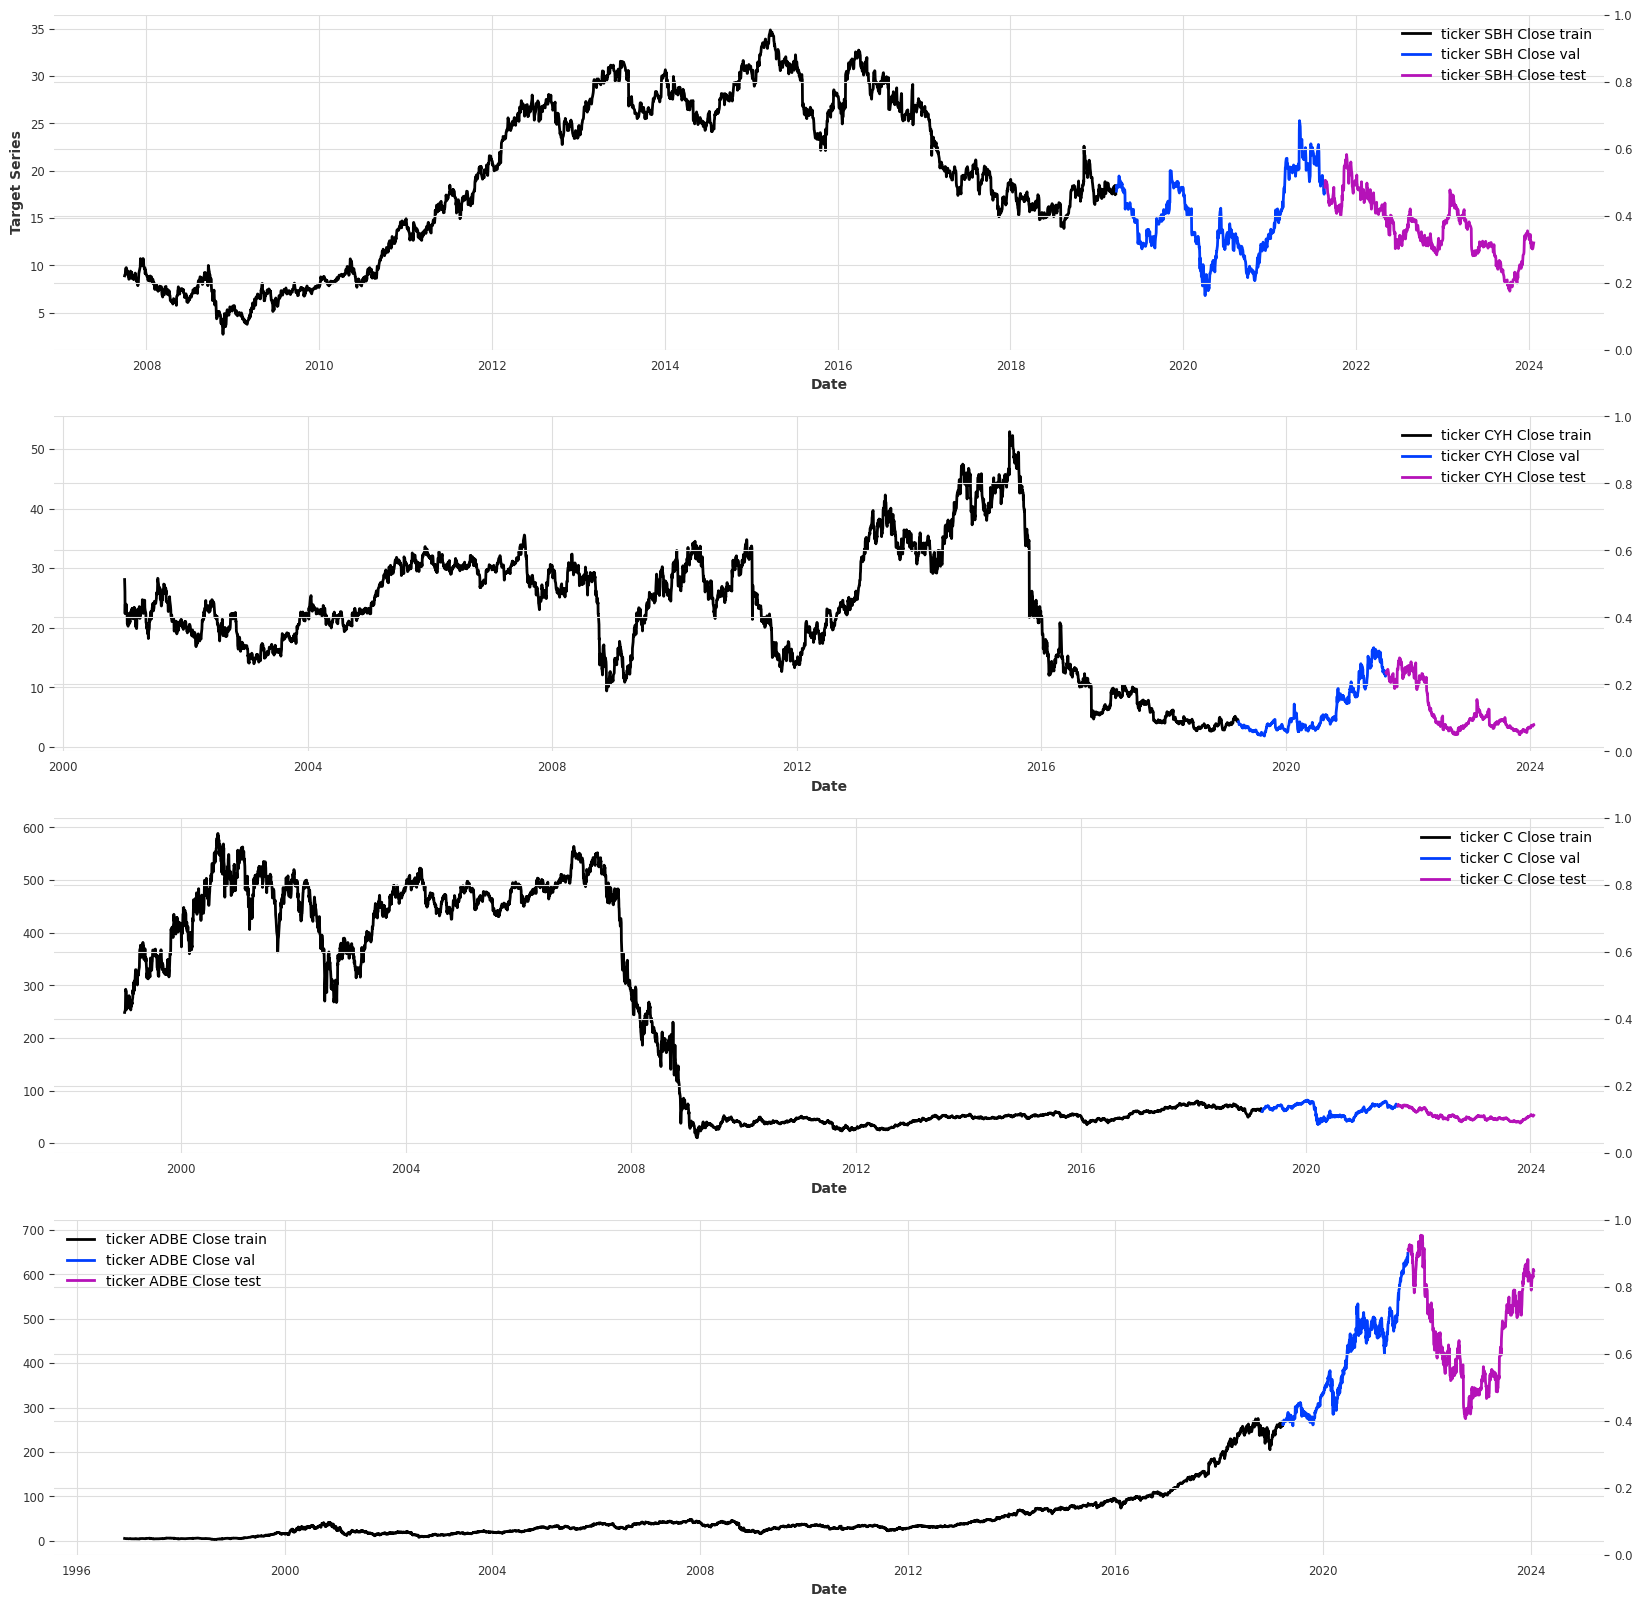

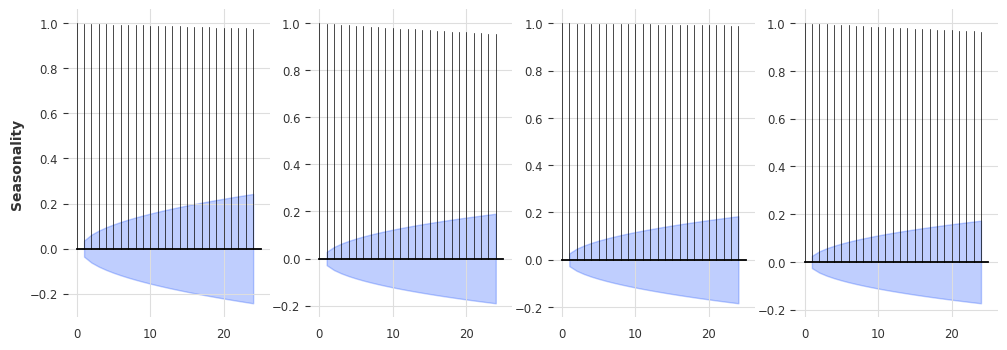

In [21]:
# prepare_data()

In [22]:
canswim_model.stock_tickers

['ONB',
 'MDT',
 'PLXS',
 'CSGS',
 'PGRE',
 'RWT',
 'NTCT',
 'FLIC',
 'BLX',
 'TER',
 'PTCT',
 'LILAK',
 'KR',
 'NEXT',
 'BJRI',
 'TNET',
 'SBH',
 'WBS',
 'WBD',
 'GMS',
 'SRDX',
 'AWI',
 'HMN',
 'CYH',
 'NEO',
 'CASS',
 'IBTX',
 'HAYN',
 'MSI',
 'VIAV',
 'NPK',
 'NVEC',
 'GDEN',
 'C',
 'FORM',
 'BDN',
 'DZSI',
 'BIG',
 'A',
 'SCVL',
 'TFX',
 'MMI',
 'JACK',
 'CAT',
 'KDP',
 'DXPE',
 'ADBE',
 'CF',
 'SCWO',
 'OCN']

In [23]:
# t = list(canswim_model.targets.target_series.keys())[0]
# t

'SBH'

In [24]:
# canswim_model.target_train_list[0].pd_dataframe()

component,Close
Date,
2000-10-31,33.127682
2000-11-01,33.485336
2000-11-02,34.424175
2000-11-03,33.485336
2000-11-06,33.172390
...,...
2019-03-18,80.970001
2019-03-19,81.199997
2019-03-20,80.919998


In [25]:
# future_covs = canswim_model.future_cov_list[0].pd_dataframe().tail(500)
# past_covs = canswim_model.past_cov_list[0].pd_dataframe().tail(500)

In [26]:
# future_covs

component,estimatedRevenueLow_p_quarter_1,estimatedRevenueHigh_p_quarter_1,estimatedRevenueAvg_p_quarter_1,estimatedEbitdaLow_p_quarter_1,estimatedEbitdaHigh_p_quarter_1,estimatedEbitdaAvg_p_quarter_1,estimatedEbitLow_p_quarter_1,estimatedEbitHigh_p_quarter_1,estimatedEbitAvg_p_quarter_1,estimatedNetIncomeLow_p_quarter_1,...,estimatedSgaExpenseAvg_p_annual_2,estimatedEpsAvg_p_annual_2,estimatedEpsHigh_p_annual_2,estimatedEpsLow_p_annual_2,numberAnalystEstimatedRevenue_p_annual_2,numberAnalystsEstimatedEps_p_annual_2,fiscalDateEnding_day_p_annual_2,fiscalDateEnding_month_p_annual_2,fiscalDateEnding_year_p_annual_2,holidays
date,,,,,,,,,,,,,,,,,,,,,
2022-02-22,1.447255e+09,1.724624e+09,1.592652e+09,329016949.0,493525423.0,411271186.0,293152542.0,439728813.0,366440677.0,220644067.0,...,1.755894e+09,5.40000,5.43000,5.40,13.0,11.0,31.0,10.0,2023.0,0.0
2022-02-23,1.447255e+09,1.724624e+09,1.592652e+09,329016949.0,493525423.0,411271186.0,293152542.0,439728813.0,366440677.0,220644067.0,...,1.755894e+09,5.40000,5.43000,5.40,13.0,11.0,31.0,10.0,2023.0,0.0
2022-02-24,1.447255e+09,1.724624e+09,1.592652e+09,329016949.0,493525423.0,411271186.0,293152542.0,439728813.0,366440677.0,220644067.0,...,1.755894e+09,5.40000,5.43000,5.40,13.0,11.0,31.0,10.0,2023.0,0.0
2022-02-25,1.447255e+09,1.724624e+09,1.592652e+09,329016949.0,493525423.0,411271186.0,293152542.0,439728813.0,366440677.0,220644067.0,...,1.755894e+09,5.40000,5.43000,5.40,13.0,11.0,31.0,10.0,2023.0,0.0
2022-02-28,1.447255e+09,1.724624e+09,1.592652e+09,329016949.0,493525423.0,411271186.0,293152542.0,439728813.0,366440677.0,220644067.0,...,1.755894e+09,5.40000,5.43000,5.40,13.0,11.0,31.0,10.0,2023.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-16,1.670000e+09,1.730000e+09,1.700000e+09,517003007.0,775504512.0,646253759.0,369287862.0,553931793.0,461609827.0,413228444.0,...,2.008721e+09,5.37579,6.14934,3.92,9.0,7.0,31.0,10.0,2025.0,0.0
2024-01-17,1.670000e+09,1.730000e+09,1.700000e+09,517003007.0,775504512.0,646253759.0,369287862.0,553931793.0,461609827.0,413228444.0,...,2.008721e+09,5.37579,6.14934,3.92,9.0,7.0,31.0,10.0,2025.0,0.0
2024-01-18,1.670000e+09,1.730000e+09,1.700000e+09,517003007.0,775504512.0,646253759.0,369287862.0,553931793.0,461609827.0,413228444.0,...,2.008721e+09,5.37579,6.14934,3.92,9.0,7.0,31.0,10.0,2025.0,0.0


In [27]:
# past_covs

component,Open,High,Low,Adj Close,Volume,eps,epsEstimated,time,revenue,revenueEstimated,...,^NDX_Low,^NDX_Close,^NDX_Adj Close,^NDX_Volume,^SPX_Open,^SPX_High,^SPX_Low,^SPX_Close,^SPX_Adj Close,^SPX_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-22,130.869995,132.690002,129.259995,128.701904,3054800.0,1.21,1.18,1.0,1.674000e+09,1.464920e+09,...,13720.919922,13870.530273,13870.530273,4.849170e+09,4332.740234,4362.120117,4267.109863,4304.759766,4304.759766,5.121900e+09
2022-02-23,129.880005,134.369995,125.949997,124.273453,3938700.0,-1.00,1.12,1.0,-1.000000e+00,1.592652e+09,...,13502.580078,13509.429688,13509.429688,4.639330e+09,4324.930176,4341.509766,4221.509766,4225.500000,4225.500000,4.797430e+09
2022-02-24,123.699997,128.630005,123.059998,126.393982,3430200.0,-1.00,1.12,1.0,-1.000000e+00,1.592652e+09,...,13065.440430,13974.669922,13974.669922,6.180200e+09,4155.770020,4294.729980,4114.649902,4288.700195,4288.700195,6.752130e+09
2022-02-25,128.839996,133.750000,127.919998,131.897507,3144500.0,-1.00,1.12,1.0,-1.000000e+00,1.592652e+09,...,13850.290039,14189.160156,14189.160156,4.628720e+09,4298.379883,4385.339844,4286.830078,4384.649902,4384.649902,5.177060e+09
2022-02-28,132.029999,132.880005,129.160004,128.573685,3096400.0,-1.00,1.12,1.0,-1.000000e+00,1.592652e+09,...,14009.360352,14237.809570,14237.809570,5.928130e+09,4354.169922,4388.839844,4315.120117,4373.939941,4373.939941,6.071370e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-16,129.139999,130.809998,128.600006,130.529999,1382100.0,-1.00,1.21,0.0,-1.000000e+00,1.587610e+09,...,16726.589844,16830.710938,16830.710938,6.386180e+09,4772.350098,4782.339844,4747.120117,4765.979980,4765.979980,4.260550e+09
2024-01-17,129.979996,130.610001,126.739998,128.119995,1257400.0,-1.00,1.21,0.0,-1.000000e+00,1.587610e+09,...,16561.490234,16736.279297,16736.279297,5.181740e+09,4739.129883,4744.229980,4714.819824,4739.209961,4739.209961,3.928600e+09
2024-01-18,128.020004,130.729996,127.529999,130.460007,1404800.0,-1.00,1.21,0.0,-1.000000e+00,1.587610e+09,...,16818.130859,16982.289062,16982.289062,5.587440e+09,4760.100098,4785.790039,4740.569824,4780.939941,4780.939941,4.019000e+09


In [28]:
# len(canswim_model.targets_list)

45

In [29]:
# len(canswim_model.target_train_list)

45

In [30]:
# len(canswim_model.past_cov_list)

45

In [31]:
# len(canswim_model.future_cov_list)

45

## Find optimal hyper parameters

In [32]:
# canswim_model.find_model()


In [33]:
# len(canswim_model.targets_list)

In [34]:
# len(canswim_model.target_train_list)

In [35]:
# len(canswim_model.past_cov_list)

In [36]:
# len(canswim_model.future_cov_list)

In [37]:
# from darts.models import TiDEModel

# model = TiDEModel.load_from_checkpoint(canswim_model.model_name)


In [38]:
# canswim_model.load_model()


In [39]:
# preds = model.predict(
#     n=model.output_chunk_length,
#     series=canswim_model.target_train_list,
#     mc_dropout=True,
#     num_samples=500,
#     past_covariates=canswim_model.past_cov_list,
#     future_covariates=canswim_model.future_cov_list,
#     num_loader_workers=4,
# )

In [40]:
# preds[0]

In [41]:
# len(preds)

In [42]:
# from darts.metrics import quantile_loss

# loss = quantile_loss(canswim_model.targets_list, preds, n_jobs=-1, verbose=True)


In [43]:
# import numpy as np
# loss_val = np.mean(loss)
# loss_val  

In [44]:
# canswim_model.test()
# canswim_model.plot_test_results()    


In [45]:
# len(canswim_model.targets_list)

In [46]:
# thorough backtest of model checkpoint
# start_list = canswim_model.get_val_start_list()
# backtest, test_error = canswim_model.backtest(series=canswim_model.targets_list[0], start=start_list[0],
#                                              past_covariates=canswim_model.past_cov_list[0], future_covariates=canswim_model.future_cov_list[0],
#                                              forecast_horizon=canswim_model.pred_horizon)        
# print(f"Backtest Quantile Loss = {test_error}")


In [47]:
# canswim_model.plot_backtest_results(target=canswim_model.targets_list[0], backtest=backtest, start=start_list[0], forecast_horizon=canswim_model.pred_horizon)    

In [48]:
# assert False

In [49]:
# if a model has not been selected and saved yet
# run a hyper parameter search
# otherwise load saved model and continue training
##if not canswim_model.load_model():
##    # find and save the optimal model configuration
##    study = canswim_model.find_model()
##    print(f'Model search study results: \n{study}')

## Build Model
  * Using optimal hyper parameters from study above

In [50]:

def build_new_model():
    canswim_model.build(            
                input_chunk_length=252,
                output_chunk_length=42,
                hidden_size=1536,
                num_encoder_layers=3,
                num_decoder_layers=3,
                decoder_output_dim=8,
                temporal_decoder_hidden=64,
                use_layer_norm=True,
                use_reversible_instance_norm=True,
                dropout=0.2,
                optimizer_kwargs={"lr": 3.5e-05},
                force_reset=False,
                save_checkpoints=False)


## Train model

### Run model training loop

In [51]:
from darts.metrics import quantile_loss
import numpy as np


def plot_backtest_results():
    # backtest on 3 stocks
    for i in range(min(len(canswim_model.targets_list),3)):
        start_list = canswim_model.get_val_start_list()
        backtest = canswim_model.backtest(target=canswim_model.targets_list[i], start=start_list[i],
                                                    past_covariates=canswim_model.past_cov_list[i], future_covariates=canswim_model.future_cov_list[i],
                                                    forecast_horizon=canswim_model.pred_horizon)        
        # print(f"target series: \n{target}")
        # print(f"backtest series: \n{backtest}")
        loss_vals = []
        for p, b in enumerate(backtest):
            loss = quantile_loss(canswim_model.targets_list[i], b, n_jobs=-1, verbose=True)
            print(f"quantile loss: {loss} at prediction step {p}")
            loss_vals.append(loss)
        mean_loss = np.mean(loss_vals)
        print(f"Mean Backtest Quantile Loss across all prediction periods: {mean_loss}")
        canswim_model.plot_backtest_results(target=canswim_model.targets_list[i], 
                                            backtest=backtest, 
                                            start=start_list[i],
                                            forecast_horizon=canswim_model.pred_horizon)        


 

In [52]:
from darts.models import TiDEModel
from canswim.hfhub import HFHub
hfhub = HFHub()


HFHub init


In [53]:
# canswim_model.load_model()

In [54]:
# canswim_model.upload_model(repo_id="ivelin/canswim")

In [56]:

# train loop
for i in range(100):
    # load latest model weights from hf hub
    canswim_model.download_model(repo_id="ivelin/canswim")    # prepare next sample subset
    prepare_data()
    # align all data series for training
    canswim_model.train()
    # push to hf hub
    canswim_model.upload_model(repo_id="ivelin/canswim")


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

n_stocks:  50
n_epochs:  5
Training loop stock subset: ['RIGL', 'SRCE', 'AMN', 'SPG', 'HCSG', 'FORM', 'MAIN', 'BG', 'TT', 'AKAM', 'JNPR', 'KFRC', 'APH', 'KDP', 'ADM', 'CBRL', 'SCVL', 'HQY', 'ADI', 'WD', 'TDG', 'CRGE', 'DUK', 'FRME', 'FMX', 'BK', 'BDN', 'WELL', 'LYB', 'NFBK', 'KRG', 'ITT', 'CCRD', 'SIX', 'RNAC', 'NYMT', 'HAYN', 'VHI', 'TMHC', 'SIGI', 'ZWS', 'SJM', 'ATSG', 'WULF', 'CAL', 'AMBA', 'NAT', 'QCOM', 'LDOS', 'SPNT']
Preparing ticker series for 50 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
Skipping RNAC due to error:  "['RNAC'] not in index"
stacking covariates
Skipping RNAC covariates stack due to erro

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | encoders              | Sequential       | 24.0 M
7 | decoders              | Sequential       | 23.8 M
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 74.4 K
-----------------------------------------------------------
48.4 M    Trainable params
0         Non-trainable params
48.4 M    Total params
193.527   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model training finished.
Model saved.
created temporary directory for model /tmp/tmpf57ciey1


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

n_stocks:  50
n_epochs:  5
Training loop stock subset: ['IVT', 'BALL', 'NVRO', 'ODC', 'PBI', 'PRU', 'CTBI', 'PJT', 'NICE', 'AIV', 'KIM', 'BGFV', 'PDFS', 'MMC', 'HZO', 'BKD', 'CRVL', 'V', 'TWI', 'JBHT', 'QCRH', 'LNTH', 'URBN', 'HPE', 'VVX', 'AES', 'TGNA', 'DHR', 'PTEN', 'BEN', 'CADE', 'AON', 'TRC', 'MSI', 'BCBP', 'PSMT', 'VGR', 'USPH', 'ERII', 'ALGN', 'POWL', 'SMLR', 'ROK', 'FLR', 'BLBD', 'UE', 'ISRG', 'RLGT', 'CLPT', 'DENN']
Preparing ticker series for 50 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
stacking covariates
preparing pas

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | encoders              | Sequential       | 24.0 M
7 | decoders              | Sequential       | 23.8 M
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 74.4 K
-----------------------------------------------------------
48.4 M    Trainable params
0         Non-trainable params
48.4 M    Total params
193.527   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model training finished.
Model saved.
created temporary directory for model /tmp/tmpjql91xqo


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

n_stocks:  50
n_epochs:  5
Training loop stock subset: ['SSB', 'HII', 'CYBR', 'LGND', 'SKY', 'OLP', 'GOOG', 'TGNA', 'MAS', 'FL', 'TBBK', 'DAL', 'TMHC', 'WABC', 'BUSE', 'SCWO', 'SQ', 'MGM', 'TBPH', 'PLUS', 'CRGE', 'CMP', 'CLW', 'CHGG', 'VRNS', 'DIOD', 'IOSP', 'CSCO', 'MRO', 'RMBS', 'BOX', 'SUN', 'TCBI', 'PAYX', 'ENTA', 'CUTR', 'SMMF', 'MTW', 'FERG', 'GRMN', 'KBH', 'BXMT', 'FET', 'EQT', 'STT', 'MDT', 'PCG', 'EIX', 'STRA', 'GCO']
Preparing ticker series for 50 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
stacking covariates
preparing p

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | encoders              | Sequential       | 24.0 M
7 | decoders              | Sequential       | 23.8 M
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 74.4 K
-----------------------------------------------------------
48.4 M    Trainable params
0         Non-trainable params
48.4 M    Total params
193.527   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model training finished.
Model saved.
created temporary directory for model /tmp/tmpkequurkg


canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

n_stocks:  50
n_epochs:  5
Training loop stock subset: ['SP', 'KEYS', 'THR', 'RCKY', 'TTSH', 'RDNT', 'REGN', 'LDOS', 'CFFI', 'IGT', 'CBT', 'BK', 'RGP', 'GRBK', 'ARCT', 'RPD', 'FFIC', 'GHC', 'SCSC', 'PLXS', 'GMRE', 'NX', 'SBUX', 'MOD', 'NDSN', 'TTEC', 'MRTN', 'KIM', 'BLNK', 'ICFI', 'HAE', 'ESRT', 'KALV', 'NRC', 'GWW', 'TGNA', 'TREE', 'TSLX', 'PFIS', 'SMTI', 'GPN', 'FGEN', 'EMR', 'HSY', 'DLTR', 'BOOT', 'SWKH', 'BBWI', 'GDEN', 'NVRO']
Preparing ticker series for 50 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
stacking covariates
prepar

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | encoders              | Sequential       | 24.0 M
7 | decoders              | Sequential       | 23.8 M
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 74.4 K
-----------------------------------------------------------
48.4 M    Trainable params
0         Non-trainable params
48.4 M    Total params
193.527   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model training finished.
Model saved.
created temporary directory for model /tmp/tmp61e_suy1


canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

n_stocks:  50
n_epochs:  5
Training loop stock subset: ['PFBC', 'FDBC', 'BBWI', 'ZBRA', 'NTRS', 'FOSL', 'NR', 'CCOI', 'EW', 'TNET', 'AVD', 'APPS', 'DDD', 'DEA', 'ABBNY', 'DGII', 'PWR', 'ULTA', 'BXP', 'TTMI', 'UNF', 'OMER', 'VUZI', 'BDN', 'STZ', 'FSLR', 'NVGS', 'BKD', 'PJT', 'SFST', 'AAON', 'HLT', 'FRST', 'STN', 'OMCL', 'ADM', 'FIS', 'NSIT', 'CATO', 'OMC', 'BHB', 'ELA', 'DECK', 'LXRX', 'RIOT', 'TCBI', 'PGC', 'LUNA', 'ASND', 'BCPC']
Preparing ticker series for 50 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
Skipping ABBNY due to error

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | encoders              | Sequential       | 24.0 M
7 | decoders              | Sequential       | 23.8 M
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 74.4 K
-----------------------------------------------------------
48.4 M    Trainable params
0         Non-trainable params
48.4 M    Total params
193.527   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model training finished.
Model saved.
created temporary directory for model /tmp/tmpmbnia4zj


canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

n_stocks:  50
n_epochs:  5
Training loop stock subset: ['BLMN', 'MVIS', 'NWSA', 'FOXF', 'FNF', 'ANSS', 'IMGN', 'STZ', 'UNTY', 'FRST', 'AROC', 'FSLR', 'EDU', 'ZBRA', 'CSGP', 'KEY', 'HNI', 'FULT', 'HOUS', 'HTBK', 'SHOP', 'ATEN', 'ATLO', 'BHE', 'CAG', 'WTW', 'USLM', 'SBGI', 'ADTN', 'AXP', 'CBU', 'NAT', 'CZFS', 'DLTR', 'LUNA', 'STGW', 'CMCO', 'RYAAY', 'KMT', 'PETS', 'COKE', 'DRQ', 'DOV', 'HST', 'XNCR', 'GLNG', 'DXCM', 'GMS', 'BJRI', 'FLS']
Preparing ticker series for 50 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
stacking covariates
pr

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | encoders              | Sequential       | 24.0 M
7 | decoders              | Sequential       | 23.8 M
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 74.4 K
-----------------------------------------------------------
48.4 M    Trainable params
0         Non-trainable params
48.4 M    Total params
193.527   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model training finished.
Model saved.
created temporary directory for model /tmp/tmpjtcm4jni


canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

n_stocks:  50
n_epochs:  5
Training loop stock subset: ['LYV', 'AVAV', 'VSH', 'INN', 'LZB', 'EXTR', 'ITCI', 'ECL', 'PVH', 'NVAX', 'SHYF', 'CBT', 'CTBI', 'PSTG', 'DXPE', 'CDZI', 'DY', 'HUM', 'ABBV', 'HDSN', 'MMYT', 'NVRO', 'MCHP', 'NHI', 'PLPC', 'SWBI', 'MPB', 'AGYS', 'WBS', 'DIN', 'BWA', 'RELL', 'BGC', 'NWE', 'IRWD', 'CBAN', 'MG', 'POWI', 'DOOR', 'AVXL', 'FTV', 'EXPE', 'ZUMZ', 'LVS', 'TBI', 'WGO', 'AXP', 'NJR', 'MITK', 'UVE']
Preparing ticker series for 50 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
stacking covariates
preparing pa

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | encoders              | Sequential       | 24.0 M
7 | decoders              | Sequential       | 23.8 M
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 74.4 K
-----------------------------------------------------------
48.4 M    Trainable params
0         Non-trainable params
48.4 M    Total params
193.527   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model training finished.
Model saved.
created temporary directory for model /tmp/tmp51kge2a8


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

n_stocks:  50
n_epochs:  5
Training loop stock subset: ['ITIC', 'BCO', 'ESRT', 'SCL', 'CAG', 'GCI', 'CSGS', 'ABUS', 'NVR', 'ETD', 'LDOS', 'SRE', 'PAYX', 'NPK', 'PFS', 'GIC', 'TARO', 'DZSI', 'RMBS', 'MKTX', 'AIZ', 'RILY', 'INTU', 'UHS', 'BECN', 'FBP', 'MDT', 'PODD', 'GLDD', 'AJG', 'LMNR', 'MCRI', 'PRAA', 'RMAX', 'SHOO', 'LGND', 'BJRI', 'ES', 'MSFT', 'BANC', 'PDSB', 'ALCO', 'TIMB', 'GCO', 'ELME', 'BX', 'TRUP', 'HON', 'SBAC', 'EGY']
Preparing ticker series for 50 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
stacking covariates
preparin

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | encoders              | Sequential       | 24.0 M
7 | decoders              | Sequential       | 23.8 M
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 74.4 K
-----------------------------------------------------------
48.4 M    Trainable params
0         Non-trainable params
48.4 M    Total params
193.527   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model training finished.
Model saved.
created temporary directory for model /tmp/tmpe52x07bz


canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

n_stocks:  50
n_epochs:  5
Training loop stock subset: ['LQDT', 'DD', 'BAC', 'PM', 'HOLI', 'KAI', 'HOUS', 'CPK', 'EXLS', 'CFG', 'TROX', 'IVT', 'FDP', 'CPSI', 'VSTO', 'ITW', 'KN', 'STE', 'FBIN', 'DXCM', 'CRK', 'PFSI', 'USNA', 'FRT', 'SQ', 'TWLO', 'UMH', 'IP', 'VRE', 'USPH', 'CZNC', 'CPSS', 'DSKE', 'NVRO', 'FL', 'FCBC', 'PSMT', 'CDNS', 'ONB', 'BIG', 'CRM', 'NL', 'ORRF', 'ATEX', 'LMT', 'KODK', 'IVAC', 'NXDT', 'OPK', 'CLX']
Preparing ticker series for 50 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
Skipping IVAC due to error: 
"['IVAC']

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | encoders              | Sequential       | 24.0 M
7 | decoders              | Sequential       | 23.8 M
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 74.4 K
-----------------------------------------------------------
48.4 M    Trainable params
0         Non-trainable params
48.4 M    Total params
193.527   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model training finished.
Model saved.
created temporary directory for model /tmp/tmpk1uz0pri


canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

n_stocks:  50
n_epochs:  5
Training loop stock subset: ['TROW', 'DG', 'BLUE', 'UCBI', 'ICFI', 'LZB', 'STRA', 'ANSS', 'ANIK', 'RCKT', 'SMLR', 'EVH', 'BANR', 'CNXN', 'NEO', 'SYF', 'ORRF', 'PR', 'BCO', 'OMC', 'CF', 'RICK', 'KR', 'FIS', 'LUMN', 'IVT', 'DLTH', 'MSFT', 'EIX', 'RYI', 'MAA', 'WNC', 'TRGP', 'HOLX', 'WERN', 'SRCE', 'SNBR', 'PGC', 'CIX', 'QLYS', 'WDC', 'CAH', 'REX', 'UPS', 'HBCP', 'BCC', 'SIX', 'NDSN', 'VLGEA', 'XNCR']
Preparing ticker series for 50 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
Skipping UPS due to error:  "['UPS'] not in index"
stacking covariates
Skipping UPS covariates stack due to error:

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | encoders              | Sequential       | 24.0 M
7 | decoders              | Sequential       | 23.8 M
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 74.4 K
-----------------------------------------------------------
48.4 M    Trainable params
0         Non-trainable params
48.4 M    Total params
193.527   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model training finished.
Model saved.
created temporary directory for model /tmp/tmpgff_y03p


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

n_stocks:  100
n_epochs:  5
Training loop stock subset: ['DDS', 'UONEK', 'JOUT', 'MRNS', 'MTX', 'TDW', 'KRG', 'NVAX', 'APO', 'FIX', 'OTLK', 'UPBD', 'BHR', 'EFC', 'CLX', 'CBZ', 'IPI', 'NVTA', 'GBX', 'PAYS', 'CMI', 'ETR', 'VOXX', 'FNF', 'PR', 'TFX', 'MODN', 'SPTN', 'IBRX', 'PGEN', 'PRFT', 'DMRC', 'AZN', 'GOOGL', 'HST', 'TROX', 'MTB', 'HURN', 'RCL', 'VRNT', 'ZWS', 'CLDX', 'HTLF', 'III', 'ABUS', 'FLEX', 'HAIN', 'CTLP', 'ORC', 'EBF', 'BWA', 'ATSG', 'WERN', 'LIVN', 'GCBC', 'GD', 'GIII', 'MAS', 'CDZI', 'GTY', 'TXRH', 'TIO', 'AWR', 'PCH', 'SYY', 'WABC', 'ESGR', 'LLY', 'VUZI', 'CIO', 'MELI', 'FORM', 'SLG', 'NECB', 'WAB', 'THR', 'MMSI', 'PACB', 'PEB', 'OFIX', 'EPM', 'SPNT', 'LMNR', 'NUE', 'NEOG', 'CRMD', 'ENV', 'FLR', 'AVGO', 'NWLI', 'HMST', 'DEA', 'BLBD', 'PAHC', 'ANSS', 'MBWM', 'CIX', 'SGMO', 'CAC', 'PCAR']
Preparing ticker series for 100 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single 

/home/ivelin/canswim/src/canswim/model.py:469: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=self.n_plot_samples, ncols=1, figsize=(20, 20))


Starting model training...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | encoders              | Sequential       | 24.0 M
7 | decoders              | Sequential       | 23.8 M
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 74.4 K
-----------------------------------------------------------
48.4 M    Trainable params
0         Non-trainable params
48.4 M    Total params
193.527   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# backtest and plot results
plot_backtest_results()


In [ ]:

# quick test progress at modelcheckpoint
# preds = canswim_model.test()
# canswim_model.plot_test_results(preds)
